In [1]:
import src.stl as stl
import numpy as np
import numpy.random as rnd
from src.kernel import StlKernel
from src.traj_measure import BaseMeasure
import pickle
import sys
import scipy.stats as stats

print(sys.getrecursionlimit())

sys.setrecursionlimit(3000)

3000


## DEFINE THE ENVIROMENT

In [25]:
class STLTreeNode(object):
    def __init__(self, args):
        self.left = None
        self.right = None
        self.node_type = args[0]
        self.node_data = args[1]
        if self.node_type =='atomic_proposition':

            self.is_branch_complete = True
            self.STLnode = self.choose_atomic_node(self.node_data['variable'],self.node_data['quartile'], self.node_data['lte'])
        elif self.node_type =='always' or self.node_type =='eventually' or self.node_type =='until':
            self.left_bound = self.node_data.get('left_bound', None)
            self.right_bound = self.node_data.get('right_bound', None)
            self.is_branch_complete = False
            self.STLnode = None
        else:
            self.is_branch_complete = False
            self.STLnode = None

    def choose_atomic_node(self, variable, quartile, lte):
        return stl.Atom(variable, quartile, lte)

    def update_node(self):
        if self.node_type == 'not':
            self.STLnode = stl.Not(self.left.STLnode)
        elif self.node_type == 'and':
            self.STLnode = stl.And(self.left.STLnode, self.right.STLnode)
        elif self.node_type == 'or':
            self.STLnode = stl.Or(self.left.STLnode, self.right.STLnode)
        elif self.node_type == 'always':
            unbound, right_unbound, left_time_bound, right_time_bound = self._get_temporal_parameters(self.left_bound, self.right_bound)
            self.STLnode = stl.Globally(
                self.left.STLnode, unbound, right_unbound, left_time_bound, right_time_bound, True
            )
        elif self.node_type == 'eventually':
            unbound, right_unbound, left_time_bound, right_time_bound = self._get_temporal_parameters(self.left_bound, self.right_bound)
            self.STLnode = stl.Eventually(
                self.left.STLnode, unbound, right_unbound, left_time_bound, right_time_bound, True
            )
        elif self.node_type == 'until':
            unbound, right_unbound, left_time_bound, right_time_bound = self._get_temporal_parameters(self.left_bound, self.right_bound)
            self.STLnode = stl.Until(
                self.left.STLnode, self.right.STLnode, unbound, right_unbound, left_time_bound, right_time_bound
            )

    def _get_temporal_parameters(self, left_bound=None, right_bound=None):
        if left_bound is None and right_bound is None:
            return True, False, 0, 0
        elif left_bound is None and right_bound is not None:
            return False, True, right_bound, 1
        else:
            return False, False, left_bound, right_bound



class STLTree(object):
    def __init__(self):
        self.root = None

    def _add_tree_root_(self,new_tree_root):
        if self.root is None:
            self.root = new_tree_root
        else:
            new_tree_root.left = self.root
            self.root = new_tree_root


    def _inorderTraversal_(self, root):
        if root.is_branch_complete is False :
            if root.left is not None:
                if root.left.is_branch_complete is True:
                    if root.right is not None:
                        return self._inorderTraversal_(root.right)
                    else:
                        return root
                else:
                    return self._inorderTraversal_(root.left)
            else:

                return root

    def _add_tree_node_(self, new_tree_node):
        if (self.root is None) or (self.root.is_branch_complete is True):
            self._add_tree_root_(new_tree_node)
        else:
            sub_root =self._inorderTraversal_(self.root)
            if sub_root.left is None:
                sub_root.left = new_tree_node
            elif sub_root.right is None:
                sub_root.right = new_tree_node
            self._update_tree_(sub_root)
        self._update_tree_(self.root)

    def _update_tree_(self, root):
        if root.is_branch_complete is True:
            return
        else:
            if (root.left is None) and (root.right is None):
                return
            elif (root.node_type =='not') or (root.node_type =='always' ) or (root.node_type =='eventually'):
                if root.left.is_branch_complete is True:
                    root.is_branch_complete = True
                    root.update_node()
                else:
                    self._update_tree_(root.left)
                    if root.left.is_branch_complete is True:
                        root.is_branch_complete = True
                        root.update_node()

            else:
                if root.right is None:
                    if root.left.is_branch_complete is False:
                        self._update_tree_(root.left)

                elif (root.left.is_branch_complete is True) and (root.right.is_branch_complete is True):
                    root.is_branch_complete = True
                    root.update_node()
                else:
                    self._update_tree_(root.right)
                    self._update_tree_(root.left)
                    if (root.left.is_branch_complete is True) and (root.right.is_branch_complete is True):
                        root.is_branch_complete = True
                        root.update_node()




    def add_node(self, args):
        self._add_tree_node_( STLTreeNode(args))

    def check_completeness(self):
        return self.root.is_branch_complete

    def get_STL_formula(self):
        if self.check_completeness():
            return self.root.STLnode
        else:
            return



In [26]:
class STLTreeEnv(object):
    def __init__(self, target_embedding, max_nodes_number):
        """
        Defines a GridWorld with start and end sites.
        """

        # Reads the position of start and end
        self.max_nodes_number = max_nodes_number
        self.start = STLTree()
        self.end = target_embedding

        # Keeps track of current state
        self.current_state = self.start
        self.current_similarity = 0
        # Keeps track of terminal state
        self.done = False

    def get_distance_from_target(self, current_embedding):
        if current_embedding.check_completeness():
            # device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            initial_std = 1.0  # standard deviation of normal distribution of initial state
            total_var_std = 1.0
            n_var=3
            mu0 = BaseMeasure( sigma0=initial_std, sigma1=total_var_std, q=0.1)
            kernel = StlKernel(mu0, samples=10000, sigma2=0.44, varn=n_var)
            similarity = kernel.compute_bag_bag([current_embedding.get_STL_formula()], [self.end]).cpu().numpy()[0][0]

            return similarity
        else:
            return 0

    def reset(self):
        """
        Resets the GridWorld to the starting position.
        """
        # Reset the environment to initial state
        self.current_state = STLTree()
        self.done = False
        self.current_similarity =0

    def step(self, A, nodes_number):
        """
        Evolves the environment given action A and current state.
        """
        # Check if action A is in proper set
        self.current_state.add_node(A)

        similarity = self.get_distance_from_target(self.current_state)
        if similarity !=0:
            reward = similarity - self.current_similarity
        else:
            reward = 0
        if similarity>self.current_similarity:
            self.current_similarity = similarity
        # If I fall over the ridge, I go back to the start and get a penalty
        if self.get_distance_from_target(self.current_state) >0.8:
            self.done = True
        if (nodes_number == self.max_nodes_number) and (self.current_similarity ==0):
            reward = - 0.8*self.max_nodes_number

        return self.current_state.get_STL_formula(), reward, self.done, self.current_similarity

class QValueNode(object):
    def __init__(self):
        self.value = 0
        self.children = {}

class QValueTree(object):
    def __init__(self):
        self.root = QValueNode()


    def add_state_action_pair(self, node, action):
        node = self.find_node(node)
        node.children[action] = QValueNode()

    def find_node(self, state):
        if not state:
            return self.root
        elif state[0] not in self.root.children:
            self.root.children[state[0]] = QValueNode()
            return self.root.children[state[0]]
        else:
            root = self.root.children[state[0]]
            for index in range(1,len(state)):
                node = root.children[state[index]]
                root  = node
            return root

    def get_state_action_pair_value(self, state, action):
        node = self.find_node(state)

        if action not in node.children:
            self.add_state_action_pair(state, action)
        return node.children[action].value

    def update_state_action_pair(self, state, action, delta):
        node = self.find_node(state)
        node.children[action].value += delta

    def find_best_qvalue(self, state, action_number, random_actions_probabilities):
        best_qvalue = 0
        best_actions = []
        if not state:
            return random_actions_probabilities
        node = self.find_node(state)
        if not node.children:
            prob_actions = random_actions_probabilities
        else:
            for child in  node.children:
                if node.children[child].value > best_qvalue:
                    best_qvalue = node.children[child].value

            for child in  node.children:
                if node.children[child].value == best_qvalue:
                    best_actions.append(child)

            prob_actions = np.zeros(action_number)
            prob_actions[best_actions] = 1/len(best_actions)

        return prob_actions

In [27]:
class SARSA_TDControl():
    def __init__(self,
                 actions_size,random_actions_probabilities,
                 gamma=1, 
                 lr_v=0.01):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.actions_size = actions_size
        self.random_actions_probabilities = random_actions_probabilities

        # the learning rate
        self.lr_v = lr_v
        
        # where to save returns
        self.Qvalues = QValueTree()

    # -------------------   
    def single_step_update(self, s, a, r, new_s, new_a, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Employs the EXPERIENCED action in the new state  <- Q(S_new, A_new).
        """
        if done:
            # in TD(0) it was
            # delta = (r + 0 - self.values[s])
            deltaQ = (r + 0 - self.Qvalues.get_state_action_pair_value(s, a) )
        else:
            # in TD(0) it was
            # delta = (r + gamma*self.values[new_s] - self.values[s])
            # Notice that I evaluate Qvalue at the new_s only for the action new_a that I really took!
            deltaQ = (r + 
                      self.gamma * self.Qvalues.get_state_action_pair_value(new_s, new_a)
                                 - self.Qvalues.get_state_action_pair_value( s,a))
            
        self.Qvalues.update_state_action_pair(s, a, self.lr_v * deltaQ)
        
    # ---------------------
    def get_action_epsilon_greedy(self, s, eps):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        ran = np.random.rand()
        
        if (ran < eps):
            # probability is uniform for all actions!
            prob_actions = self.random_actions_probabilities
        
        else:
            prob_actions = self.Qvalues.find_best_qvalue(s, self.actions_size,self.random_actions_probabilities )
            
        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.actions_size, p=prob_actions)
        return a 
        
    def greedy_policy(self):
        greedy_pol = np.argmax(self.Qvalues, axis = 2)
        return greedy_pol

In [ ]:
class Qlearning_TDControl():
    def __init__(self,
             actions_size,random_actions_probabilities,
             gamma=1,
             lr_v=0.01):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """
        # the discount factor
        self.gamma = gamma
        # size of system
        self.actions_size = actions_size
        self.random_actions_probabilities = random_actions_probabilities

        # the learning rate
        self.lr_v = lr_v

        # where to save returns
        self.Qvalues = QValueTree()

    def single_step_update(self, s, a, r, new_s, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Uses the BEST (evaluated) action in the new state <- Q(S_new, A*) = max_A Q(S_new, A).
        """
        if done:
            # in TD(0) it was
            # delta = (r + 0 - self.values[s])
            deltaQ = (r + 0 - self.Qvalues[ (*s, a) ])
        else:
            # in TD(0) it was
            # delta = (r + gamma*self.values[new_s] - self.values[s])
            # Notice that use the maximum of new Q function for the new function !
            maxQ_over_actions = np.max(self.Qvalues[ (*new_s,) ])

            deltaQ = (r +
                      self.gamma * maxQ_over_actions
                                 - self.Qvalues[ (*s,a) ])

        self.Qvalues[ (*s, a) ] += self.lr_v * deltaQ

    # -------------------
    def single_step_update(self, s, a, r, new_s, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Employs the EXPERIENCED action in the new state  <- Q(S_new, A_new).
        """
        if done:
            # in TD(0) it was
            # delta = (r + 0 - self.values[s])
            deltaQ = (r + 0 - self.Qvalues.get_state_action_pair_value(s, a) )
        else:
            # in TD(0) it was
            # delta = (r + gamma*self.values[new_s] - self.values[s])
            # Notice that I evaluate Qvalue at the new_s only for the action new_a that I really took!
            maxQ_over_actions = np.max(self.Qvalues[ (*new_s,) ])

            deltaQ = (r +
                      self.gamma * self.Qvalues.get_state_action_pair_value(new_s, new_a)
                                 - self.Qvalues.get_state_action_pair_value( s,a))

        self.Qvalues.update_state_action_pair(s, a, self.lr_v * deltaQ)

    # ---------------------
    def get_action_epsilon_greedy(self, s, eps):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        ran = np.random.rand()

        if (ran < eps):
            # probability is uniform for all actions!
            prob_actions = self.random_actions_probabilities

        else:
            prob_actions = self.Qvalues.find_best_qvalue(s, self.actions_size,self.random_actions_probabilities )

        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.actions_size, p=prob_actions)
        return a

    def greedy_policy(self):
        greedy_pol = np.argmax(self.Qvalues, axis = 2)
        return greedy_pol





In [28]:
from src.phis_generator import StlGenerator
prob_unbound_time_operator = 0.1  # probability of a temporal operator to have a time bound of the type [0,infty]
prob_right_unbound_time_operator = 0.1  # probability of a temporal operator to have a time bound of the type [a, infty]
leaf_probability = 0.5  # probability of generating a leaf (always zero for root)
atom_threshold_sd = 1.0  # std for the normal distribution of the thresholds of atoms

In [29]:
node_types = ['atomic_proposition', 'not', 'and','or','always','eventually','until']
max_nodes_number = 30
num_variables = 3
max_right_bound = 10
max_timespan = 20

# Percentiles of a standard normal distribution
percentiles = {p: stats.norm.ppf(p / 100) for p in range(1, 100)}
quartiles = [percentiles[i]*atom_threshold_sd+0 for i in range(3,100,5)]
Actions = []
atomic_probability = 0
temporal_probability = 0
for node_type in node_types:
    if node_type == 'atomic_proposition':
        for variable in range(num_variables):
            for quartile in quartiles:
                for lte in [True,False]:
                    atomic_probability +=1
                    Actions.append((node_type, {'variable':variable, 'quartile':quartile, 'lte':lte}))
    elif node_type =='always' or node_type =='eventually' or node_type =='until':
        for right_bound in range(1, max_right_bound):
            for left_bound in [None]+list(range(1,right_bound)):
                temporal_probability+=1
                Actions.append((node_type, {'left_bound':left_bound, 'right_bound':right_bound}))
        atomic_probability +=1
        Actions.append((node_type, {'left_bound':None, 'right_bound':None}))
    else:
        Actions.append((node_type, None))
random_actions_probabilities = [1/(atomic_probability*7)]*atomic_probability +[1/7]*3+ [3/(7*temporal_probability)]*temporal_probability

[0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.0011614401858304297, 0.00116144

In [ ]:
gamma = 1.0
# learning rate
lr_v = 0.1
n_episodes = 2000
epsilon = 0.15
rewards_data = {}
for target in  range(20):
    rewards_data[target] = []
    # set environment!-----------------------
    # ----------------- Start   End
    target_embedding = StlGenerator(leaf_prob=leaf_probability, time_bound_max_range=max_right_bound,
                           unbound_prob=prob_unbound_time_operator, right_unbound_prob=prob_right_unbound_time_operator,
                           threshold_sd=atom_threshold_sd, inner_node_prob=[0.2, 0.2, 0.2, 0.2, 0.2, 0],
                           max_timespan=max_timespan).sample(num_variables)
    print(target_embedding)
    env = STLTreeEnv(target_embedding,max_nodes_number)


    # ---------------------------------------
    # gamma

    # Initialize
    SARSA = SARSA_TDControl( actions_size=len(Actions),random_actions_probabilities = random_actions_probabilities, gamma=gamma, lr_v=0.15)
    performance_traj_SARSA = np.zeros(n_episodes)
    atomic_predicates= []
    # RUN OVER EPISODES
    for i in range(n_episodes):
        done = False
        env.reset()
        s = []
        a = SARSA.get_action_epsilon_greedy(s, epsilon)
        act = Actions[a]
        new_s = s.copy()
        rewards=0
        for steps in range(max_nodes_number+1):
            # Evolve one step|
            formula, r, done, current_similarity = env.step(act, steps)
            SARSA.Qvalues.add_state_action_pair(s, a)
            rewards+=r
            # Save observed reward
            new_s += [a]
            # Choose new action index
            new_a = SARSA.get_action_epsilon_greedy(new_s, epsilon)
            if r>0:
                print(r)
            SARSA.single_step_update(s, a, r, new_s, new_a, done)
            act = Actions[new_a]
            a = new_a
            s = new_s.copy()
            if done:
                atomic_predicates.append(formula)
                break

            # if count > tstar:
            #     # UPDATE OF LEARNING
            #     ExpSARSA.lr_v = lr_v_0/(1 + 0.003*(count - tstar)**0.75)
            #     # UPDATE OF EPSILON
            #     epsilon = epsilon_0/(1. + 0.005*(count - tstar)**1.05)
        print('trajectory_done')
        rewards_data[target].append([rewards, current_similarity])
        with open(f'frewards_data', 'wb') as file:
                pickle.dump(rewards_data, file)
        if i%100==0:
            with open(f'{target}_SARSA_data', 'wb') as file:
                pickle.dump(SARSA, file)



Qvalues = SARSA.Qvalues


always ( x_0 >= 0.9542 )
0.40860515832901
0.085853845
0.0015144944
trajectory_done
trajectory_done
0.3341437876224518
0.0070177317
trajectory_done
trajectory_done
trajectory_done
0.33188068866729736
trajectory_done
0.08677594363689423
0.0011421219
trajectory_done
0.012082749046385288
8.633826e-05
0.06648417
0.018530637
0.002335444
0.29232737
0.006343454
0.0071409345
0.04117921
trajectory_done
0.037034474313259125
0.000801377
0.00874088
0.32638535
0.00033086538
0.0098056495
0.378865
trajectory_done
0.4404677748680115
trajectory_done
0.09126497805118561
trajectory_done
0.23773673176765442
0.087950826
0.020432293
trajectory_done
0.4477222263813019
0.0014565885
2.5629997e-05
0.12972343
trajectory_done
0.05016530305147171
trajectory_done
0.24886609613895416
0.0026299804
0.005501747
0.13566846
0.011219531
trajectory_done
0.5867865681648254
trajectory_done
0.47117772698402405
trajectory_done
0.35931918025016785
0.011331439
trajectory_done
0.024473542347550392
0.38606027
trajectory_done
trajec

In [40]:
rewards_data

{0: [[0.5875827670097351, 0.63580304],
  [-24.0, 0],
  [0.29404132813215256, 0.3588571],
  [-0.2541227154433727, 0.13912255],
  [0.20335274934768677, 0.20335275],
  [-0.39947807788848877, 0.5644859],
  [-24.0, 0],
  [0.4444175101816654, 0.44490963],
  [-24.0, 0],
  [0.011639034375548363, 0.06448484],
  [-24.0, 0],
  [0.09096096456050873, 0.090960965]]}

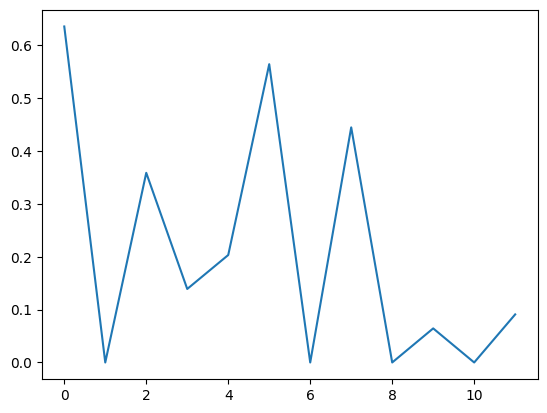

In [58]:
import matplotlib.pyplot as plt
second_elements = [tup[1] for tup in rewards_data[0]]
plt.plot(list(range(len(rewards_data[0]))), second_elements)
plt.show()

In [59]:
rewards_data[0]

[[0.5875827670097351, 0.63580304],
 [-24.0, 0],
 [0.29404132813215256, 0.3588571],
 [-0.2541227154433727, 0.13912255],
 [0.20335274934768677, 0.20335275],
 [-0.39947807788848877, 0.5644859],
 [-24.0, 0],
 [0.4444175101816654, 0.44490963],
 [-24.0, 0],
 [0.011639034375548363, 0.06448484],
 [-24.0, 0],
 [0.09096096456050873, 0.090960965]]